In [132]:
using CSV, DataFrames
using DelaunayTriangulation
using StaticArrays
using LinearAlgebra
using CairoMakie
using Statistics

# Calcule la normale d'un triangle 3D
function normale(tri_pts)
    p1, p2, p3 = tri_pts
    v1, v2 = SVector(p2 .- p1), SVector(p3 .- p1)
    n = cross(v1, v2)
    return norm(n) == 0 ? n : n / norm(n)
end

# Calcule la pente en mrad entre deux normales
function angle_entre_normales(n1, n2)
    teta = acos(clamp(dot(n1, n2), -1.0, 1.0))
    return teta * 1000  # mrad
end

# Calcule la pente en mrad entre deux normales
function aire(p1, p2, p3)
    return 0.5 * abs((p2[1] - p1[1]) * (p3[2] - p1[2]) - (p2[2] - p1[2]) * (p3[1] - p1[1]))
end


aire (generic function with 2 methods)

In [133]:

# Chargement des points depuis un fichier CSV
df = CSV.read("14111.csv", DataFrame, header=false, delim=';')
rename!(df, [:x, :y, :z])
points = [(df.x[i], df.y[i], df.z[i]) for i in 1:nrow(df)]
points_xy = [(p[1], p[2]) for p in points]

533-element Vector{Tuple{Float64, Float64}}:
 (-56.698, -33.576)
 (-56.747, -28.686)
 (-56.757, -23.786)
 (-56.759, -18.879)
 (-56.759, -13.98)
 (-52.013, 35.052)
 (-52.01, 30.174)
 (-52.01, 25.278)
 (-52.01, 20.376)
 (-52.01, 15.473)
 ⋮
 (52.348, -23.77)
 (52.347, -28.673)
 (52.347, -33.575)
 (52.347, -38.482)
 (57.088, 10.532)
 (57.088, 15.452)
 (57.088, 20.357)
 (57.088, 25.262)
 (57.088, 30.166)

In [134]:

# Triangulation de Delaunay sur le plan XY
#maillage = triangulate(xy; delete_ghosts = true)
maillage = triangulate(points_xy)

aires = [aire(points[tri[1]],points[tri[2]],points[tri[3]]) for tri in each_solid_triangle(maillage)]
aire_moy = mean(aires)
aire_limite = aire_moy * .1

1.1440257644444445

In [135]:
angles_aretes = Dict{Tuple{Int, Int}, Float64}()
for arete in each_solid_edge(maillage)
    s1, s2 = get_adjacent(maillage, arete[1], arete[2]), get_adjacent(maillage, arete[2], arete[1]) # Sommets de part et d'autre de l'arete (-1 si pas de sommet)
    if s1 != -1 && s2 != -1
        a1 = aire((points[arete[1]], points[arete[2]], points[s1]))
        a2 = aire((points[arete[2]], points[arete[1]], points[s2]))
        if a1 > aire_limite && a2 > aire_limite
            n1 = normale((points[arete[1]], points[arete[2]], points[s1]))
            n2 = normale((points[arete[2]], points[arete[1]], points[s2]))
            angle = angle_entre_normales(n1, n2)
            push!(angles_aretes, arete => angle)
        end
    end
end
angles_aretes

Dict{Tuple{Int64, Int64}, Float64} with 1504 entries:
  (380, 376) => 0.938955
  (147, 121) => 0.614059
  (270, 293) => 5.09863
  (104, 66)  => 4.67393
  (388, 387) => 5.5392
  (516, 531) => 7.50889
  (487, 488) => 4.86129
  (477, 467) => 1.1766
  (481, 462) => 4.68998
  (187, 230) => 6.42716
  (313, 346) => 4.66411
  (115, 102) => 3.4466
  (115, 114) => 5.24204
  (34, 50)   => 6.31591
  (504, 503) => 5.09919
  (180, 137) => 6.07593
  (362, 345) => 4.8949
  (97, 74)   => 1.17009
  (378, 425) => 182.35
  ⋮          => ⋮

In [136]:
#min_angle, max_angle = extrema(values(angles_aretes))
max_angle = maximum(values(angles_aretes))
min_angle = minimum(values(angles_aretes))
#min_angle = median(values(angles_aretes))
#min_angle = .5 * max_angle

0.0

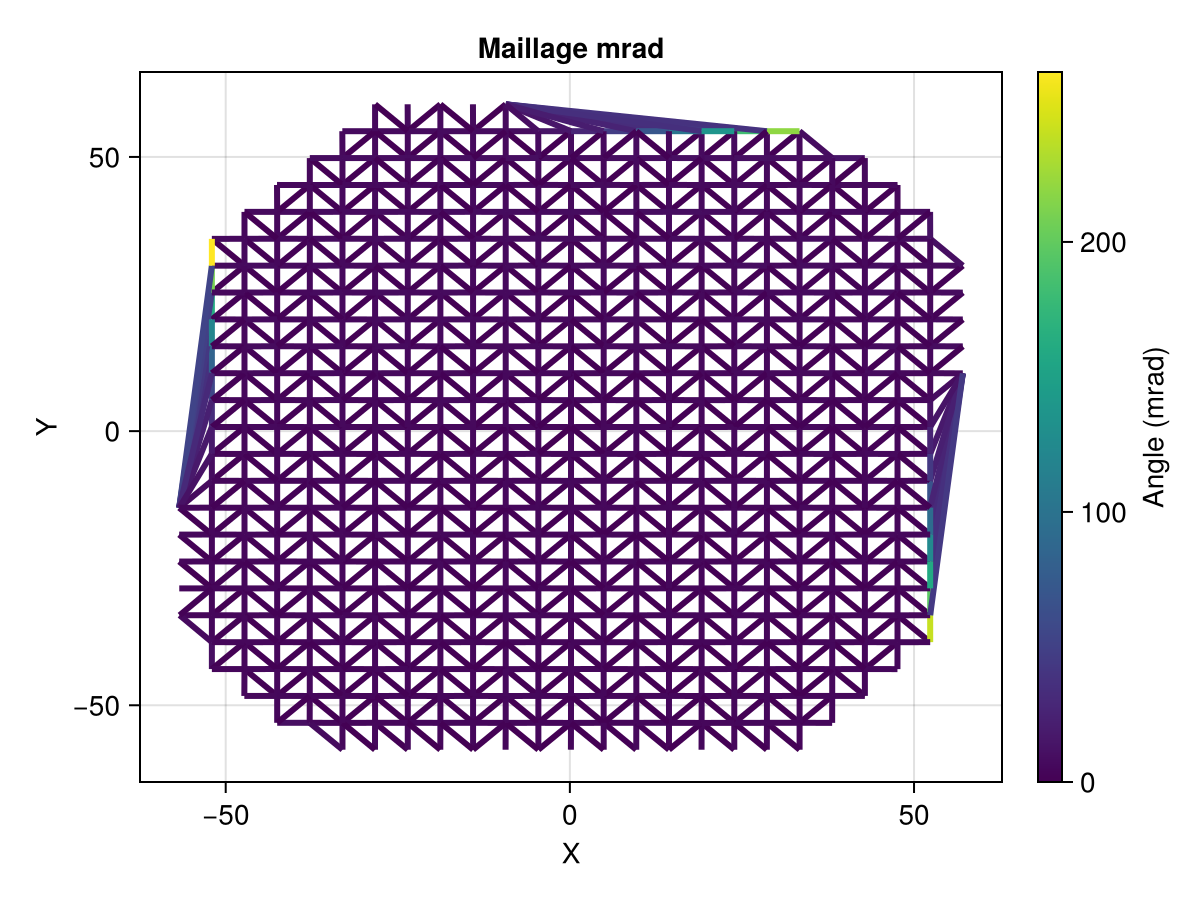

In [137]:
fig = Figure()
ax = Axis(fig[1, 1], title="Maillage mrad", xlabel="X", ylabel="Y")

for (arete, angle) in angles_aretes
    p1, p2 = points[arete[1]], points[arete[2]]
    color = cgrad(:viridis)[(angle - min_angle) / (max_angle - min_angle)]
    lines!(ax, [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=3)
end

# for (arete, angle) in angles_aretes
#     if angle > min_angle
#         p1, p2 = points[arete[1]], points[arete[2]]
#         color = cgrad(:viridis)[(angle - min_angle) / (max_angle - min_angle)]
#         lines!(ax, [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=3)
#     end
# end

# Ajouter une barre de couleur
Colorbar(fig[1, 2], colormap=:viridis, label="Angle (mrad)", limits=(min_angle, max_angle))

# Afficher la figure
fig